In [1]:
import pandas as pd
import gc
import os
import re
import json
from pathlib import Path
from os.path import join as path_join
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [2]:
nn_train_path = Path("dataset/nn_train.parquet")
nn_test_path = Path("dataset/nn_test.parquet")

In [3]:
pd.read_parquet(nn_train_path)

,code,target
0,&& aa1 - a0 aa1 aa1 -- aa1 aa1 \ \...,6
1,if let Aa1 ( aa1 ) = request . aa1 ( )...,21
2,-- Aa1 source code is aa1 aa1 aa...,14
3,aaA2 ( aaA2 . aaA1 . text . aaA1 ( ) ) \n ...,13
4,aaA2 : ( AaA1 < AaA1 *>* ) aaA2 \n ...,16
...,...,...
109503,@ AaA2 ( ) \n aa_2 : string ; \n \n ...,27
109504,"aa1 . aa_1 ( ) . clone ( ) , \n ...",21
109505,* Aa1 aa1 aa2 aa1 . \n * \n ...,17
109506,"Aa1 ( "" aa2 generic arguments : ` Aa1 ( ...",21


In [4]:
tglangs = """
TGLANG_LANGUAGE_OTHER
TGLANG_LANGUAGE_C
TGLANG_LANGUAGE_CPLUSPLUS
TGLANG_LANGUAGE_CSHARP
TGLANG_LANGUAGE_CSS
TGLANG_LANGUAGE_DART
TGLANG_LANGUAGE_DOCKER
TGLANG_LANGUAGE_FUNC
TGLANG_LANGUAGE_GO
TGLANG_LANGUAGE_HTML
TGLANG_LANGUAGE_JAVA
TGLANG_LANGUAGE_JAVASCRIPT
TGLANG_LANGUAGE_JSON
TGLANG_LANGUAGE_KOTLIN
TGLANG_LANGUAGE_LUA
TGLANG_LANGUAGE_NGINX
TGLANG_LANGUAGE_OBJECTIVE_C
TGLANG_LANGUAGE_PHP
TGLANG_LANGUAGE_POWERSHELL
TGLANG_LANGUAGE_PYTHON
TGLANG_LANGUAGE_RUBY
TGLANG_LANGUAGE_RUST
TGLANG_LANGUAGE_SHELL
TGLANG_LANGUAGE_SOLIDITY
TGLANG_LANGUAGE_SQL
TGLANG_LANGUAGE_SWIFT
TGLANG_LANGUAGE_TL
TGLANG_LANGUAGE_TYPESCRIPT
TGLANG_LANGUAGE_XML
"""

tglanguages_to_idx = {idx - 1: tglang.strip().split("TGLANG_LANGUAGE_")[1] for (idx, tglang) in
                      filter(
                          lambda li: li[1].strip(),
                          enumerate(tglangs.split("\n"))
                      )}
tglanguages_to_idx

{0: 'OTHER',
 1: 'C',
 2: 'CPLUSPLUS',
 3: 'CSHARP',
 4: 'CSS',
 5: 'DART',
 6: 'DOCKER',
 7: 'FUNC',
 8: 'GO',
 9: 'HTML',
 10: 'JAVA',
 11: 'JAVASCRIPT',
 12: 'JSON',
 13: 'KOTLIN',
 14: 'LUA',
 15: 'NGINX',
 16: 'OBJECTIVE_C',
 17: 'PHP',
 18: 'POWERSHELL',
 19: 'PYTHON',
 20: 'RUBY',
 21: 'RUST',
 22: 'SHELL',
 23: 'SOLIDITY',
 24: 'SQL',
 25: 'SWIFT',
 26: 'TL',
 27: 'TYPESCRIPT',
 28: 'XML'}

In [14]:
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader

class LoaderBuilder():
    def __init__(self, batch_size=64, tokens_len=4096):
        self.token_2_id = None
        self.id_2_token = None
        self.tokens_len = tokens_len
        self.batch_size = batch_size
    
    def build(self, path, is_train: bool = True):
        data = pd.read_parquet(path)

        if is_train:
            token_2_id = {
                "[NONE]": 0,
                "[UNKNOWN]": 1
            }
            id_2_token = {
                0: "[NONE]",
                1: "[UNKNOWN]"
            }

            rows = list(map(str.split, data["code"].to_list()))
            for row in rows:
                for token in row:
                    if token not in token_2_id:
                        token_id = len(token_2_id)
                        token_2_id[token] = token_id
                        id_2_token[token_id] = token

            self.token_2_id = token_2_id
            self.id_2_token = id_2_token

        X = []

        for row in list(map(lambda text: text.split()[:self.tokens_len], data["code"].to_list())):
            ids = [0 for i in range(self.tokens_len)]

            for i in range(len(row)):
                if row[i] in self.token_2_id:
                    ids[i] = self.token_2_id[row[i]]
                else:
                    ids[i] = self.token_2_id["[UNKNOWN]"]

            X.append(ids)

        X = np.array(X)
        y = data["target"].to_numpy()

        print(X.shape, y.shape)

        tensor_dataset = TensorDataset(
            torch.tensor(X),
            torch.tensor(y)
        )
        loader = DataLoader(tensor_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True)

        return loader

In [15]:
loader_builder = LoaderBuilder(batch_size=128, tokens_len=32)
train_loader = loader_builder.build(nn_train_path, True)
test_loader = loader_builder.build(nn_test_path, False)

len(loader_builder.token_2_id)

(109430, 32) (109430,)
(33313, 32) (33313,)


5537

In [16]:
LABEL_LEN = 29

class Net(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, d_model):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)
        self.emb_bias = nn.Parameter(torch.zeros([embedding_dim]))

        self.l2 = nn.Linear(embedding_dim, d_model)
        self.nonl1 = nn.ReLU()

        self.l3 = nn.Linear(d_model, d_model)
        self.nonl2 = nn.ReLU()

        self.l4 = nn.Linear(d_model, d_model)
        self.nonl3 = nn.ReLU()

        self.classifier = nn.Linear(d_model, LABEL_LEN, bias=False)

    def forward(self, x):
        y = (x != 0).float().sum(dim=1).unsqueeze(-1)        
        x = self.emb(x)
        x = x.sum(dim=1)
        x = x / y
        x = x + self.emb_bias
        x = self.nonl1(self.l2(x))
        x = self.nonl2(self.l3(x))
        x = self.nonl3(self.l4(x))
        x = self.classifier(x)
        return x

class NetRnn(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_dim, n_layers=1):
        super().__init__()
        self.my_hidden_dim = hidden_dim
        self.my_n_layers   = n_layers
        
        self.emb = nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)

        self.rnn = nn.RNN(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True
        )

        self.classifier = nn.Linear(hidden_dim, LABEL_LEN, bias=False)

    def forward(self, x):
        x = self.emb(x)
        output, hidden = self.rnn(x, torch.randn(self.my_n_layers, len(x), self.my_hidden_dim))
        x = self.classifier(output[:,-1])

        return x

def evaluator(net, test_iter):
    criterion = nn.CrossEntropyLoss()

    rmse_list = []
    for idx, (tokens, target) in enumerate(test_iter):
        loss = criterion(net(tokens), target.long())
        
        rmse_list.append(loss.detach())

    return float(np.mean(np.array(rmse_list)))

def acc_evaluator(net, test_iter):
    criterion = nn.CrossEntropyLoss()

    correct = 0
    total   = 0
    
    for idx, (tokens, target) in enumerate(test_iter):
        predict = torch.argmax(nn.functional.softmax(net(tokens)), dim=1)
        correct += torch.sum(predict == target).item()
        total   += target.size()[0]

    return correct / total

In [18]:
num_embeddings = len(loader_builder.token_2_id)
embedding_dim = 32
d_model = 512

# model = Net(num_embeddings, embedding_dim, d_model)
model = NetRnn(num_embeddings, embedding_dim, 32, n_layers=1)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 50
train_loss = []
test_loss  = []

is_val = True

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data)
model.apply(weights_init)

print(model)

for epoch in range(num_epochs):
    for idx, (tokens, target) in enumerate(train_loader):
        # Set gradients to zero
        optimizer.zero_grad()

        # Predict and calculate loss
        prediction = model(tokens)

        loss = loss_func(prediction, target.long())

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()
    
    train_loss.append(acc_evaluator(model, train_loader))
    test_loss.append(acc_evaluator(model, test_loader))

    if is_val:
        print("Epoch:", epoch)
        print("Train accuracy", train_loss[-1])
        print("Test accuracy", test_loss[-1])

NetRnn(
  (emb): Embedding(5537, 32, padding_idx=0)
  (rnn): RNN(32, 32, batch_first=True)
  (classifier): Linear(in_features=32, out_features=29, bias=False)
)


/var/folders/dz/7q462fh56rg95y4_6lnqmrvr0000gq/T/ipykernel_11726/2750061991.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predict = torch.argmax(nn.functional.softmax(net(tokens)), dim=1)


Epoch: 0
Train accuracy 0.09945843091334895
Test accuracy 0.08479567307692308
Epoch: 1
Train accuracy 0.08183913934426229
Test accuracy 0.06929086538461539
Epoch: 2
Train accuracy 0.06749487704918032
Test accuracy 0.05721153846153846
Epoch: 3
Train accuracy 0.10368486533957845
Test accuracy 0.10078125
Epoch: 4
Train accuracy 0.10798448477751757
Test accuracy 0.09098557692307692
Epoch: 5
Train accuracy 0.07857325819672131
Test accuracy 0.06817908653846154
Epoch: 6
Train accuracy 0.06066122658079625
Test accuracy 0.052223557692307694
Epoch: 7
Train accuracy 0.07842688817330211
Test accuracy 0.07169471153846153
Epoch: 8
Train accuracy 0.07644174473067916
Test accuracy 0.0907451923076923
Epoch: 9
Train accuracy 0.08128110362997658
Test accuracy 0.09939903846153846
Epoch: 10
Train accuracy 0.08281798887587823
Test accuracy 0.0993389423076923
Epoch: 11
Train accuracy 0.08352239461358314
Test accuracy 0.137890625
Epoch: 12
Train accuracy 0.07684426229508197
Test accuracy 0.0959735576923077
Ep

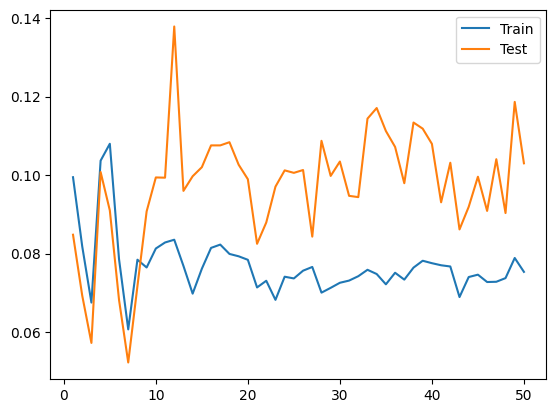

In [19]:
import matplotlib.pyplot as plt 

x = list(range(1, num_epochs + 1))

plt.plot(x, train_loss, label="Train")
plt.plot(x, test_loss, label = "Test")
plt.legend(loc='best')
plt.show()

In [20]:
y_true = []
y_pred = []

for tokens, target in test_loader:
    y_true += target.tolist()
    y_pred += torch.argmax(nn.functional.softmax(model(tokens)), dim=1).tolist()

y_true = [tglanguages_to_idx[x] for x in y_true]
y_pred = [tglanguages_to_idx[x] for x in y_pred]

/var/folders/dz/7q462fh56rg95y4_6lnqmrvr0000gq/T/ipykernel_11726/3031830772.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred += torch.argmax(nn.functional.softmax(model(tokens)), dim=1).tolist()


<Axes: title={'center': 'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

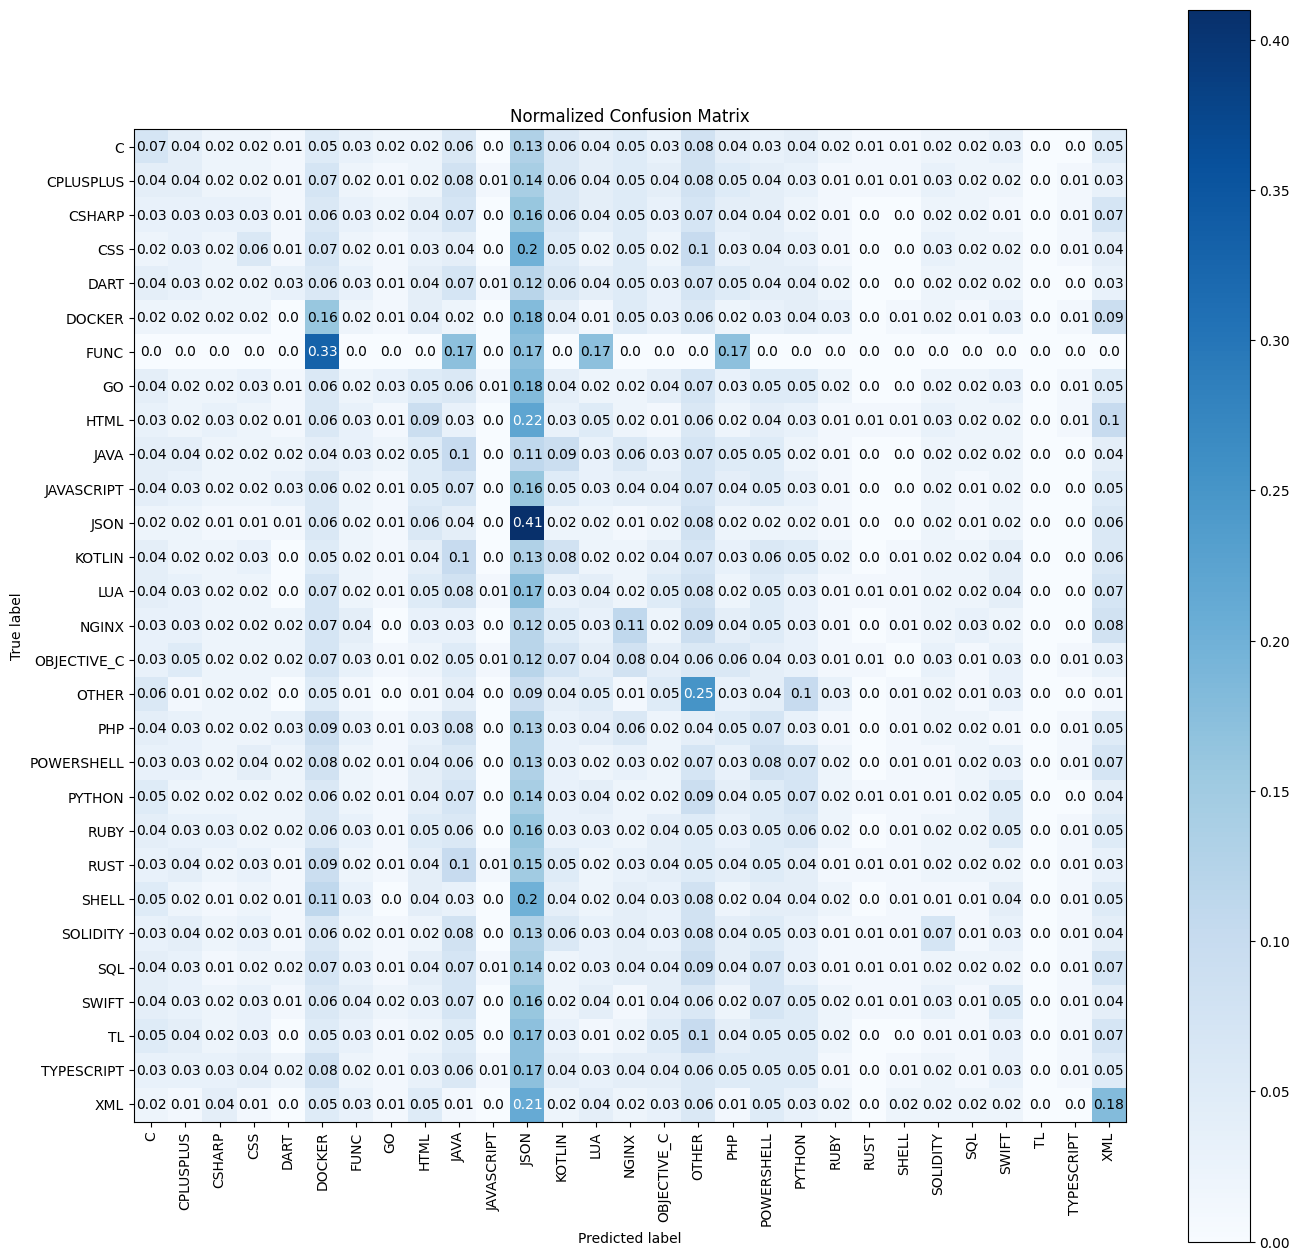

In [21]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_true,
    y_pred,
    normalize='all',
    figsize=(16,16),x_tick_rotation=90)